<a href="https://colab.research.google.com/github/guptapallavi30/AmazonProductReviewScoring/blob/main/AmazonFashionReviewScorePredictionModel_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Note__

This projects initial goal was to predict the density of upvotes based on a review's entire text attributes, the verification of the reviewer, and the overall score deemed by the reviewer.

Attempts were made to reduce the skewed data of vote distribution, and different models were created. Ultimately, the model's accuracy and goal was altered to simplify the greater goal of learning the works and mechanism of integrating a model with Flask and Docker.

Therefore, the new goal of the model is to use the entire review text, verification of the reviewer, and the vote classification to predict the overall score the reviewer might give to a product.

In [8]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import sklearn
import joblib
import scipy
from scipy.sparse import hstack
import sys


In [13]:
print("sklearn version:", sklearn.__version__)
print("joblib version:", joblib.__version__)
print("scipy version:", scipy.__version__)
print(sys.version)
# print("Seaborn version:", sns.__version__)

sklearn version: 1.2.2
joblib version: 1.3.2
scipy version: 1.10.1
3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


# Dataset Retrieval

*Here, we will unzip our data that was retrieved/downloaded from a secondary source.*

Below are the links to access the files:
- https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/
- https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews

**Citation**

Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering
R. He, J. McAuley
WWW, 2016
pdf

Image-based recommendations on styles and substitutes
J. McAuley, C. Targett, J. Shi, A. van den Hengel
SIGIR, 2015
pdf

In [ ]:
### load the meta data

data = []
with gzip.open('AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

883636
{'overall': 5.0, 'verified': True, 'reviewTime': '10 20, 2014', 'reviewerID': 'A1D4G1SNUZWQOT', 'asin': '7106116521', 'reviewerName': 'Tracy', 'reviewText': 'Exactly what I needed.', 'summary': 'perfect replacements!!', 'unixReviewTime': 1413763200}


In [ ]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)

print(len(df))

883636


# Data Preprocessing

In [ ]:
for col in df.columns:
  print(col)
  print(df[col].isna().value_counts())
  print("-------")

overall
False    883636
Name: overall, dtype: int64
-------
verified
False    883636
Name: verified, dtype: int64
-------
reviewTime
False    883636
Name: reviewTime, dtype: int64
-------
reviewerID
False    883636
Name: reviewerID, dtype: int64
-------
asin
False    883636
Name: asin, dtype: int64
-------
reviewerName
False    883544
True         92
Name: reviewerName, dtype: int64
-------
reviewText
False    882403
True       1233
Name: reviewText, dtype: int64
-------
summary
False    883103
True        533
Name: summary, dtype: int64
-------
unixReviewTime
False    883636
Name: unixReviewTime, dtype: int64
-------
vote
True     803736
False     79900
Name: vote, dtype: int64
-------
style
True     579067
False    304569
Name: style, dtype: int64
-------
image
True     854829
False     28807
Name: image, dtype: int64
-------


In [ ]:
# Drop columns irrelevant to this goal
df2 = df.drop(columns=['reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'style', 'image','reviewTime'])

In [ ]:
# Replace NaN values in 'vote' with 0
df2['vote'].fillna(0, inplace=True)

In [ ]:
# Ensure uniform type in column 'vote'
df2.vote = df2.vote.astype(int)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Get value counts and convert to a 2D array
vote_counts = df2['vote'].value_counts().reset_index()
vote_counts.columns = ['vote', 'count']  # Rename columns for clarity

# Convert 'vote' column to integer if necessary
vote_counts['vote'] = vote_counts['vote'].astype(int)

# Sort the 2D array by index 0 (first column)
sorted_vote_counts = vote_counts.values[vote_counts['vote'].argsort()]

In [ ]:
len(sorted_vote_counts)

201

## Determine Distribution of Vote

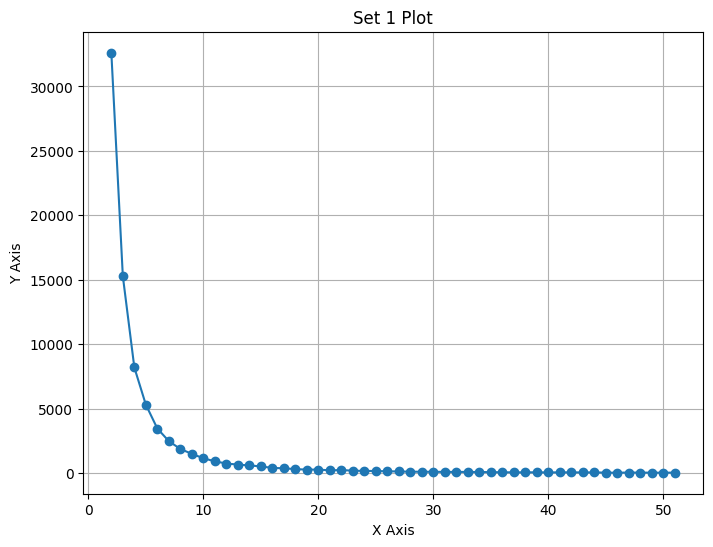

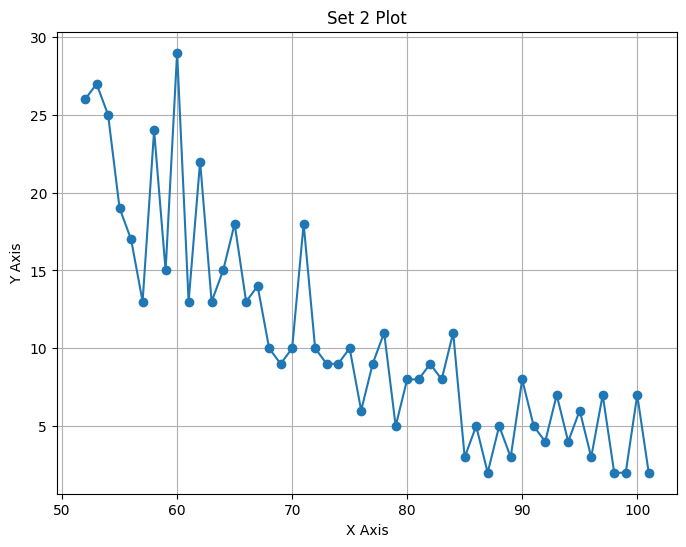

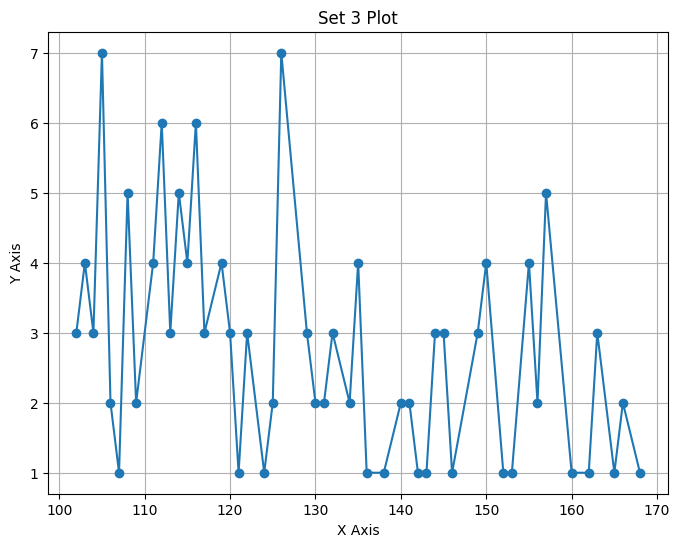

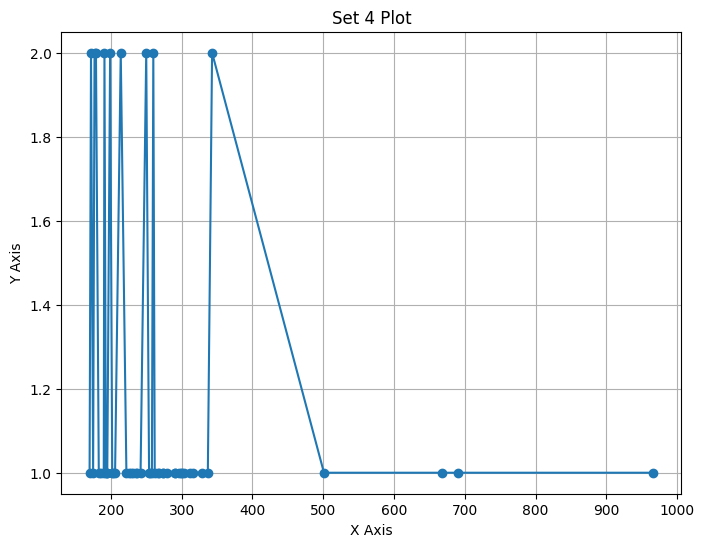

In [ ]:
# Define the interval for creating subplots
interval = 50

# Divide the sorted_vote_counts into sets of 50 elements
sorted_vote_sets = [sorted_vote_counts[i:i+interval] for i in range(1, len(sorted_vote_counts), interval)]

# Plot each set in its own graph
for idx, subset in enumerate(sorted_vote_sets):
    plt.figure(figsize=(8, 6))
    plt.plot(subset[:, 0], subset[:, 1], marker='o')
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.title(f'Set {idx + 1} Plot')
    plt.grid(True)
    plt.show()


In [ ]:
# Get the indices of 2D elements whose 0th index is 50
indices = np.where(sorted_vote_counts[:, 0] == 50)[0][0]
indices
start = 1
for i in [25, 100, sorted_vote_counts[len(sorted_vote_counts) - 1][0]]:
    index = np.where(sorted_vote_counts[:, 0] == 50)[0][0]
    print('sum of: ' + str(start) + ' till ' + str(i))
    print(np.sum(sorted_vote_counts[start:i+1, 1]))
    start = i

sum of: 1 till 25
77777
sum of: 25 till 100
2052
sum of: 100 till 966
200


In [ ]:
lower_threshold = 25
higher_threshold = 100
# Define a function to classify values
def classify_votes(vote):
    if vote < lower_threshold:
        return 0 # 'low'
    elif vote < higher_threshold:
        return 1 # 'medium'
    else:
        return 2 # 'high

# Apply the function to create a new column
df2['voteClassification'] = df2['vote'].apply(classify_votes)
df3 = df2.drop(columns=['vote'])

## Combine Text attributes from reviews

In [ ]:
# Replace NaN values in 'reviewText' and 'summary' with 0
df3['reviewText'].fillna('', inplace=True)
df3['summary'].fillna('', inplace=True)

In [ ]:
# Merge the two columns and create a new column
df3['mergedText'] = df3['reviewText'] + ' ' + df3['summary']

df4 = df3.drop(columns=['reviewText', 'summary'])

In [ ]:
len(df4[df4['mergedText'].str.strip() == ''])

33

In [ ]:
# Remove rows where 'Name' column is empty
df4 = df4[df4['mergedText'].str.strip() != '']

In [ ]:
len(df4[df4['mergedText'].str.strip() == ''])

0

In [ ]:
df4

,overall,verified,voteClassification,mergedText
0,5.0,True,0,Exactly what I needed. perfect replacements!!
1,2.0,True,0,"I agree with the other review, the opening is ..."
2,4.0,False,0,Love these... I am going to order another pack...
3,2.0,True,0,too tiny an opening Two Stars
4,3.0,False,0,Okay Three Stars
...,...,...,...,...
883631,5.0,True,0,I absolutely love this dress!! It's sexy and ...
883632,5.0,True,0,I'm 5'6 175lbs. I'm on the tall side. I wear a...
883633,3.0,True,0,Too big in the chest area! Three Stars
883634,3.0,True,0,"Too clear in the back, needs lining Three Stars"


In [ ]:
rows_with_both_null = df4[(df4.mergedText.isnull())]
rows_with_both_null

,overall,verified,voteClassification,mergedText


In [ ]:
# Convert boolean column to integers
df4['verifiedEncoded'] = df4['verified'].astype(int)

df5 = df4.drop(columns=['verified'])

In [ ]:
df5['overall'] = df5['overall'].astype(int)

In [ ]:
df5.overall.value_counts()

5    465447
4    149331
1    107076
3     97031
2     64718
Name: overall, dtype: int64

## Pre-Processed DF

In [ ]:
df5

,overall,voteClassification,mergedText,verifiedEncoded
0,5,0,Exactly what I needed. perfect replacements!!,1
1,2,0,"I agree with the other review, the opening is ...",1
2,4,0,Love these... I am going to order another pack...,0
3,2,0,too tiny an opening Two Stars,1
4,3,0,Okay Three Stars,0
...,...,...,...,...
883631,5,0,I absolutely love this dress!! It's sexy and ...,1
883632,5,0,I'm 5'6 175lbs. I'm on the tall side. I wear a...,1
883633,3,0,Too big in the chest area! Three Stars,1
883634,3,0,"Too clear in the back, needs lining Three Stars",1


## 'ReviewText' Attribute Processing

In [ ]:
# Clean and preprocess the text data by removing stopwords, punctuation, and other irrelevant information.
# Tokenize the text data into individual words or subwords.
# Convert the text data into a suitable format for modeling (e.g., TF-IDF, word embeddings).
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Rejoin tokens into cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [ ]:
df5['reviewsCleaned'] = df5['mergedText'].apply(preprocess_text)

In [ ]:
preprocess_text(df5.mergedText[2])

"love ... going order another pack keep work someone including always losing back earring n't understand fish hook earrings n't wish tiny bit longer new 'friends"

In [ ]:
df5

,overall,voteClassification,mergedText,verifiedEncoded,reviewsCleaned
0,5,0,Exactly what I needed. perfect replacements!!,1,exactly needed perfect replacements
1,2,0,"I agree with the other review, the opening is ...",1,agree review opening small almost bent hook ex...
2,4,0,Love these... I am going to order another pack...,0,love ... going order another pack keep work so...
3,2,0,too tiny an opening Two Stars,1,tiny opening two stars
4,3,0,Okay Three Stars,0,okay three stars
...,...,...,...,...,...
883631,5,0,I absolutely love this dress!! It's sexy and ...,1,absolutely love dress 's sexy comfortable spli...
883632,5,0,I'm 5'6 175lbs. I'm on the tall side. I wear a...,1,'m 5 6 175lbs 'm tall side wear large ordered ...
883633,3,0,Too big in the chest area! Three Stars,1,big chest area three stars
883634,3,0,"Too clear in the back, needs lining Three Stars",1,clear back needs lining three stars


## Save Processed DF to prevent re-creating for next steps

In [ ]:
# Save DataFrame to a CSV file
df5.to_csv('amazon_fashion_processed_df.csv', index=False)

from google.colab import files

# Download the CSV file
files.download('amazon_fashion_processed_df.csv')

## Upload Processed DF

In [1]:
import pandas as pd

# Provide the path to your uploaded CSV file
csv_file_path = "amazon_fashion_processed_df.csv"

# Read the CSV file into a Pandas DataFrame
df5 = pd.read_csv(csv_file_path)

In [4]:
# Remove rows with missing values
df5 = df5.dropna()
df5.shape

(883579, 5)

In [5]:
df5.drop(columns=["mergedText", "voteClassification", "verifiedEncoded"], inplace=True)

In [6]:
df5

,overall,reviewsCleaned
0,5,exactly needed perfect replacements
1,2,agree review opening small almost bent hook ex...
2,4,love ... going order another pack keep work so...
3,2,tiny opening two stars
4,3,okay three stars
...,...,...
883598,5,absolutely love dress 's sexy comfortable spli...
883599,5,'m 5 6 175lbs 'm tall side wear large ordered ...
883600,3,big chest area three stars
883601,3,clear back needs lining three stars


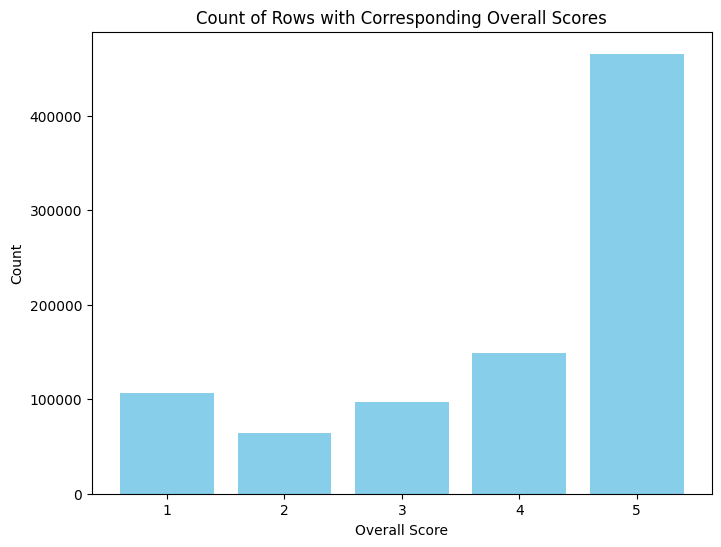

In [9]:
# create graph for plotting how many rows for each 'overall' value

# Count the occurrences of each Overall score
score_counts = df5['overall'].value_counts().sort_index()

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(score_counts.index, score_counts.values, color='skyblue')
plt.xlabel('Overall Score')
plt.ylabel('Count')
plt.title('Count of Rows with Corresponding Overall Scores')
plt.xticks(score_counts.index)
plt.show()


# Creating Models

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## RandomForestClassifier - predicting 'Overall'

In [11]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target (y)
X = df5[['reviewsCleaned']]
y = df5['overall']  # Assuming you have a label indicating popularity

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((706863, 1), (176716, 1), (706863,), (176716,))

### RandomUnderSampler

In [12]:
from imblearn.under_sampling import RandomUnderSampler

# Create a RandomUnderSampler for balancing classes
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling to the training data
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train.to_frame())
X_train_resampled.shape, y_train_resampled.shape

((258835, 1), (258835, 1))

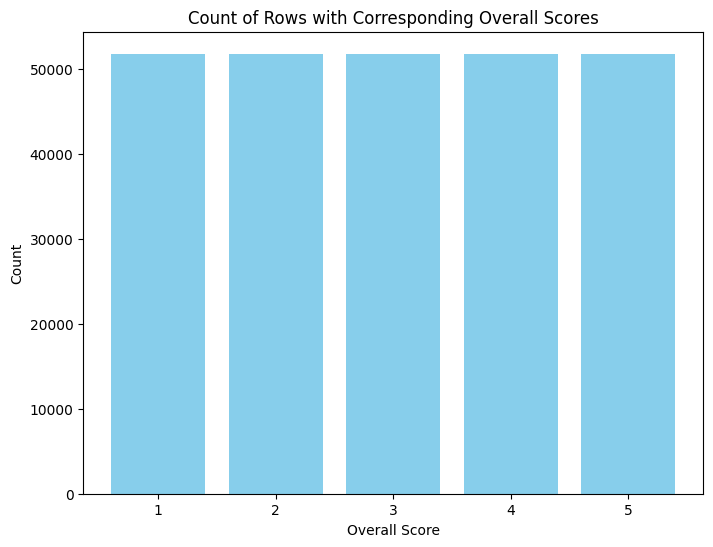

In [13]:
# create graph for plotting how many rows for each 'overall' value

# Count the occurrences of each Overall score
score_counts_RUS = y_train_resampled['overall'].value_counts().sort_index()

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(score_counts_RUS.index, score_counts_RUS.values, color='skyblue')
plt.xlabel('Overall Score')
plt.ylabel('Count')
plt.title('Count of Rows with Corresponding Overall Scores')
plt.xticks(score_counts_RUS.index)
plt.show()


In [16]:
X_train_resampled['reviewsCleaned']

0         two pair pants fit well think women 's big siz...
1                     feels looks really cheap n't like fan
2         ordered pink plaid pants blue plaid pants blue...
3         arms long baggy rest short narrow looks missha...
4         fascinator came unglued n't able wear could n'...
                                ...                        
258830    n't wo n't yet maybe one day fits well n item ...
258831    perfect 6 3 150lbs got medium fit great afraid...
258832    omg theyre perfect would absolutely buy omg th...
258833    best smelling non candles 'm using store 2 zip...
258834    love adjustable string hat cute light weight g...
Name: reviewsCleaned, Length: 258835, dtype: object

### TfidfVectorizer

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed

# Transform the text column
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_resampled['reviewsCleaned'])

### Train

In [ ]:
# from scipy.sparse import hstack

# # Convert 'overall' and 'verifiedEncoded' to a sparse matrix
# X_train_numerical = X_train_resampled[['voteClassification', 'verifiedEncoded']].values

# # Combine TF-IDF features with numerical features
# X_train_combined = hstack([X_train_tfidf, X_train_numerical])

In [19]:
y_train_resampled['overall']

0         1
1         1
2         1
3         1
4         1
         ..
258830    5
258831    5
258832    5
258833    5
258834    5
Name: overall, Length: 258835, dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the combined features
# rf_classifier.fit(X_train_tfidf, np.squeeze(y_train_resampled))
rf_classifier.fit(X_train_tfidf, y_train_resampled['overall'])

In [ ]:
# Transform the text column in X_test using the same TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test['reviewsCleaned'])

# Combine TF-IDF features with numerical features for X_test
# X_test_numerical = X_test[['voteClassification', 'verifiedEncoded']].values
# X_test_combined = hstack([X_test_tfidf])

# Predict on the test data
y_pred = rf_classifier.predict(X_test_tfidf)

In [ ]:
y_pred.shape

(176716,)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report for more detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.7332952307657484
              precision    recall  f1-score   support

           1       0.72      0.80      0.76     21426
           2       0.45      0.54      0.50     12951
           3       0.56      0.56      0.56     19372
           4       0.54      0.64      0.59     29867
           5       0.92      0.81      0.86     93100

    accuracy                           0.73    176716
   macro avg       0.64      0.67      0.65    176716
weighted avg       0.75      0.73      0.74    176716



### Attempt Prediction

In [3]:
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/ML/AmazonFashionReviewScoreClassifier/amazon_fashion_overall_score_generator_model_3.pkl'
tfidf_path = '/content/drive/MyDrive/ML/AmazonFashionReviewScoreClassifier/tfidf_vectorizer_3.pkl'


import joblib

# Load the model using joblib
with open(model_path, 'rb') as file:
    my_model = joblib.load(file)

# Load the TF-IDF vectorizer using joblib
with open(tfidf_path, 'rb') as file:
    my_tfidf = joblib.load(file)


# Now you can work with the 'data' object in your Colab notebook

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:

new_data = {
    'reviewsCleaned': 'i like it but i think the arm holes could be bigger. The color was super nice and the faabric is also soft.',
    # 'voteClassification': 0,
    # 'verifiedEncoded': 0
}

# Transform the text column
new_text_tfidf = my_tfidf.transform([new_data['reviewsCleaned']])

# # Combine TF-IDF features with numerical features for the new data
# new_numerical = [[new_data['voteClassification'], new_data['verifiedEncoded']]]
# new_combined = hstack([new_text_tfidf, new_numerical])

# Predict on the new data
new_prediction = my_model.predict(new_text_tfidf)

print("Predicted Vote Classification:", new_prediction)

Predicted Vote Classification: [4]


### Save model and TF-IDF vectorizer

In [ ]:
import joblib

# Save the trained model
joblib.dump(rf_classifier, 'amazon_fashion_overall_score_generator_model_3.pkl')

# Save the tfidf_vectorizer as a file
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer_3.pkl')

In [ ]:
from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# Train and fit your RandomForestClassifier and TfidfVectorizer
# Assuming you have already trained rf_classifier and tfidf_vectorizer

# Save the trained model and vectorizer to your Google Drive
model_filename = '/content/drive/MyDrive/ML/AmazonFashionReviewScoreClassifier/amazon_fashion_overall_score_generator_model_3.pkl'
vectorizer_filename = '/content/drive/MyDrive/ML/AmazonFashionReviewScoreClassifier/tfidf_vectorizer_3.pkl'

# Save the model
joblib.dump(rf_classifier, model_filename)

# Save the TfidfVectorizer
joblib.dump(tfidf_vectorizer, vectorizer_filename)

print("Model and vectorizer saved to Google Drive.")

### Compression into lzma

In [ ]:
import lzma

input_pickle_file = 'amazon_fashion_overall_score_generator_model_2.pkl'
compressed_output_file = 'compressed_amazon_fashion_overall_score_generator_model_2.xz'

with open(input_pickle_file, 'rb') as input_file, lzma.open(compressed_output_file, 'wb') as output_file:
    lzma.compressfile(input_file, output_file)


## Models for 'Vote Classification' Prediction

### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target (y)
X = df5[['reviewsCleaned', 'overall', 'verifiedEncoded']]
y = df5['voteClassification']  # Assuming you have a label indicating popularity

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((167520, 3), (41880, 3), (167520,), (41880,))

### ColumnTransformer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer for text
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed

In [ ]:
tfidf_vectorizer

TfidfVectorizer(max_features=5000)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features (OverallScore and Verification)
num_features = ['overall', 'verifiedEncoded']
num_transformer = StandardScaler()

In [ ]:
num_transformer

StandardScaler()

In [ ]:
from sklearn.compose import ColumnTransformer

# Create a preprocessor for the text and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('text', tfidf_vectorizer, 'reviewsCleaned'),
        ('num', num_transformer, num_features)
    ],
    remainder='passthrough'
)

In [ ]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('text', TfidfVectorizer(max_features=5000),
                                 'reviewsCleaned'),
                                ('num', StandardScaler(),
                                 ['overall', 'verifiedEncoded'])])

### RandomUnderSampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Create a RandomUnderSampler for balancing classes
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Apply undersampling to the training data
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train.to_frame())
X_train_resampled.shape, y_train_resampled.shape

((216, 3), (216, 1))

### RandomForestClassifier - predicting 'Vote Classification'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Create a pipeline with TF-IDF vectorizer for text, standard scaler for numeric features, and Random Forest classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

### Logistic Regression - predicting 'Vote Classification'

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression

# # Create a machine learning pipeline
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', LogisticRegression(max_iter=1000))
# ])

# # Train the model using resampled data
# pipeline.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text',
                                                  TfidfVectorizer(max_features=5000),
                                                  'reviewsCleaned'),
                                                 ('num', StandardScaler(),
                                                  ['overall',
                                                   'verifiedEncoded'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [ ]:
# from sklearn.metrics import accuracy_score

# # Make predictions
# y_pred = pipeline.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.10f}')

# df_pred = pd.DataFrame(y_pred, columns = ['prediction'])
# df_pred.value_counts(), y_test.value_counts()

Accuracy: 0.4614487625


(prediction
 0             22880
 2             14044
 1             12815
 dtype: int64,
 0    49520
 1      195
 2       24
 Name: voteClassification, dtype: int64)

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, balanced_accuracy_score

# # Calculate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Calculate precision, recall, and F1-score
# classification_rep = classification_report(y_test, y_pred)

# # Calculate balanced accuracy
# balanced_acc = balanced_accuracy_score(y_test, y_pred)

# print("Confusion Matrix:")
# print(conf_matrix)
# print("\nClassification Report:")
# print(classification_rep)
# print("Balanced Accuracy:", balanced_acc)


Confusion Matrix:
[[13670 25300 10550]
 [    8   136    51]
 [    0    17     7]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.28      0.43     49520
           1       0.01      0.70      0.01       195
           2       0.00      0.29      0.00        24

    accuracy                           0.28     49739
   macro avg       0.34      0.42      0.15     49739
weighted avg       1.00      0.28      0.43     49739

Balanced Accuracy: 0.42171754829266944


### SVC - predicting 'Vote Classification'

In [ ]:
# from sklearn.svm import SVC

# # Create a machine learning pipeline
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier',  SVC())  # You can use any classifier you prefer
# ])

# # Train the model
# pipeline.fit(X_train_resampled, y_train_resampled)

# # Make predictions
# y_pred_svm = pipeline.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred_svm)
# print(f'Accuracy: {accuracy:.10f}')

# df_pred_svm = pd.DataFrame(y_pred_svm, columns = ['prediction'])
# df_pred_svm.value_counts(), y_test.value_counts()

Accuracy: 0.2777096443


(prediction
 1             25453
 0             13678
 2             10608
 dtype: int64,
 0    49520
 1      195
 2       24
 Name: voteClassification, dtype: int64)

### Neural Network - predicting 'Vote Classification'

In [ ]:
# # Transform the data using the preprocessor
# X_train_processed = preprocessor.fit_transform(X_train_resampled)
# X_test_processed = preprocessor.transform(X_test)

# X_train_processed.shape, X_test_processed.shape

((237, 2887), (49739, 2887))

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

# # Transform the data using the preprocessor
# X_train_processed = preprocessor.fit_transform(X_train_resampled)
# X_test_processed = preprocessor.transform(X_test)

# # Convert SparseTensor to dense array
# X_train_dense = X_train_processed.toarray()
# X_test_dense = X_test_processed.toarray()

# # Build a neural network model using Keras
# model = Sequential([
#     Dense(32, activation='relu', input_dim=X_train_dense.shape[1]),  # Input layer
#     Dropout(0.5),  # Dropout layer for regularization
#     Dense(64, activation='relu'),  # Hidden layer
#     Dropout(0.5),  # Dropout layer for regularization
#     Dense(1, activation='sigmoid')  # Output layer
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train_dense, y_train_resampled, epochs=10, batch_size=1, validation_data=(X_test_dense, y_test))



In [ ]:
# # Evaluate the model
# loss, accuracy = model.evaluate(X_test_dense, y_test)
# print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

1555/1555 [==============================] - 4s 2ms/step - loss: 530.7581 - accuracy: 0.1353
Loss: 530.7581, Accuracy: 0.1353
